In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:
hue_data = pd.read_csv('data/HUE/1hour/Residential_27.csv', parse_dates=True).sort_values(by=['date', 'hour'])
pecan_data = pd.read_csv('data/Pecanstreet/participants_data/1hour/features/661_test_30_all_features.csv')

In [26]:
hue_data.energy_kWh.describe().transpose()

count    10579.000000
mean         0.815311
std          1.063290
min          0.000000
25%          0.140000
50%          0.300000
75%          1.150000
max          7.030000
Name: energy_kWh, dtype: float64

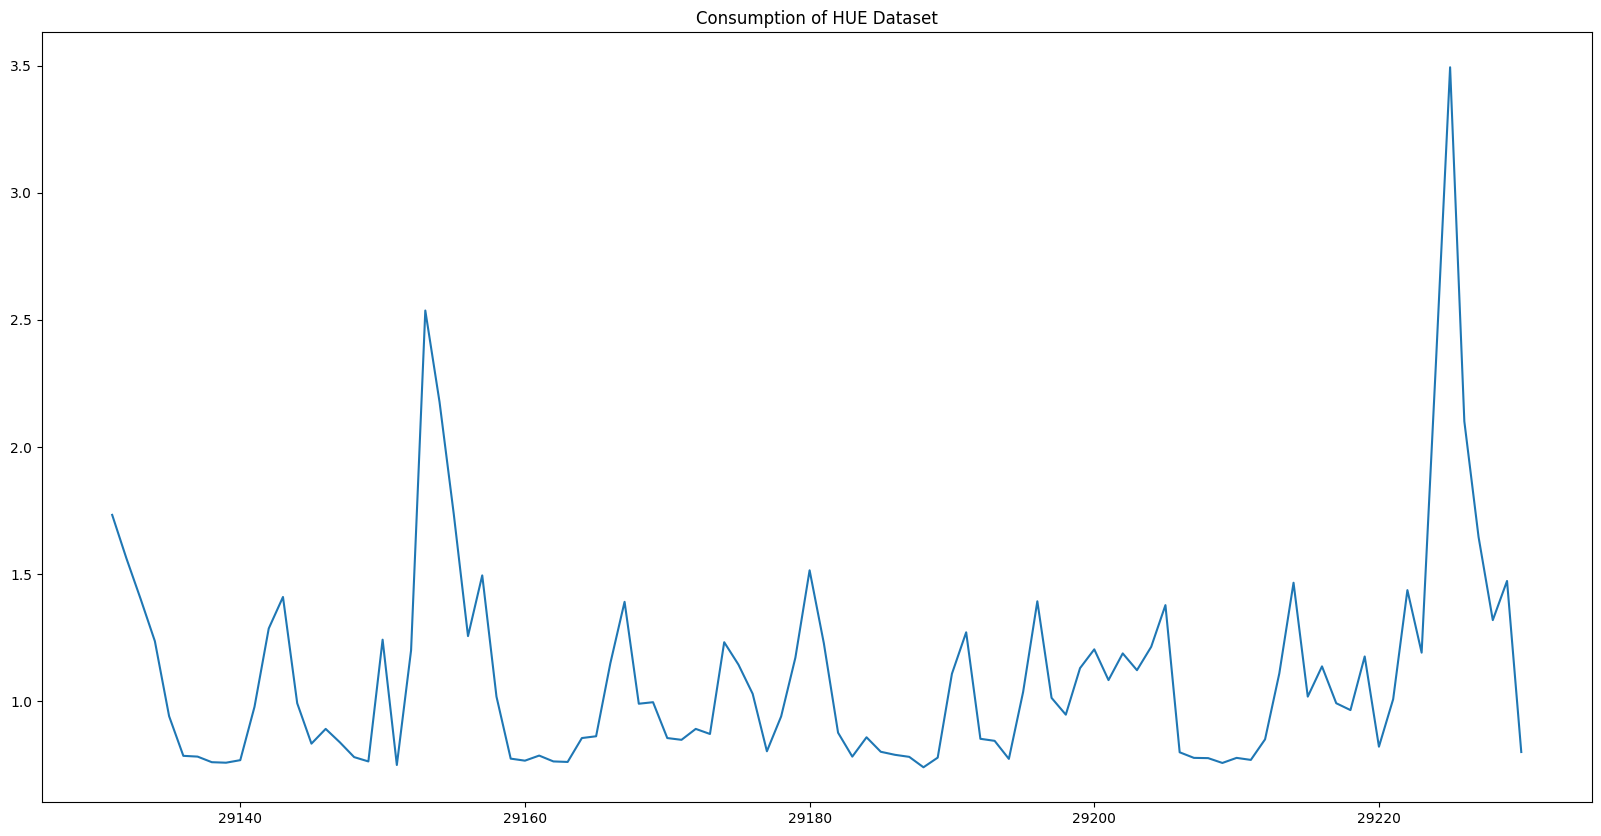

In [15]:
plt.figure(figsize=(20,10))
plt.title('Consumption of HUE Dataset')
plt.plot(hue_data.energy_kWh[-100:])
plt.show()

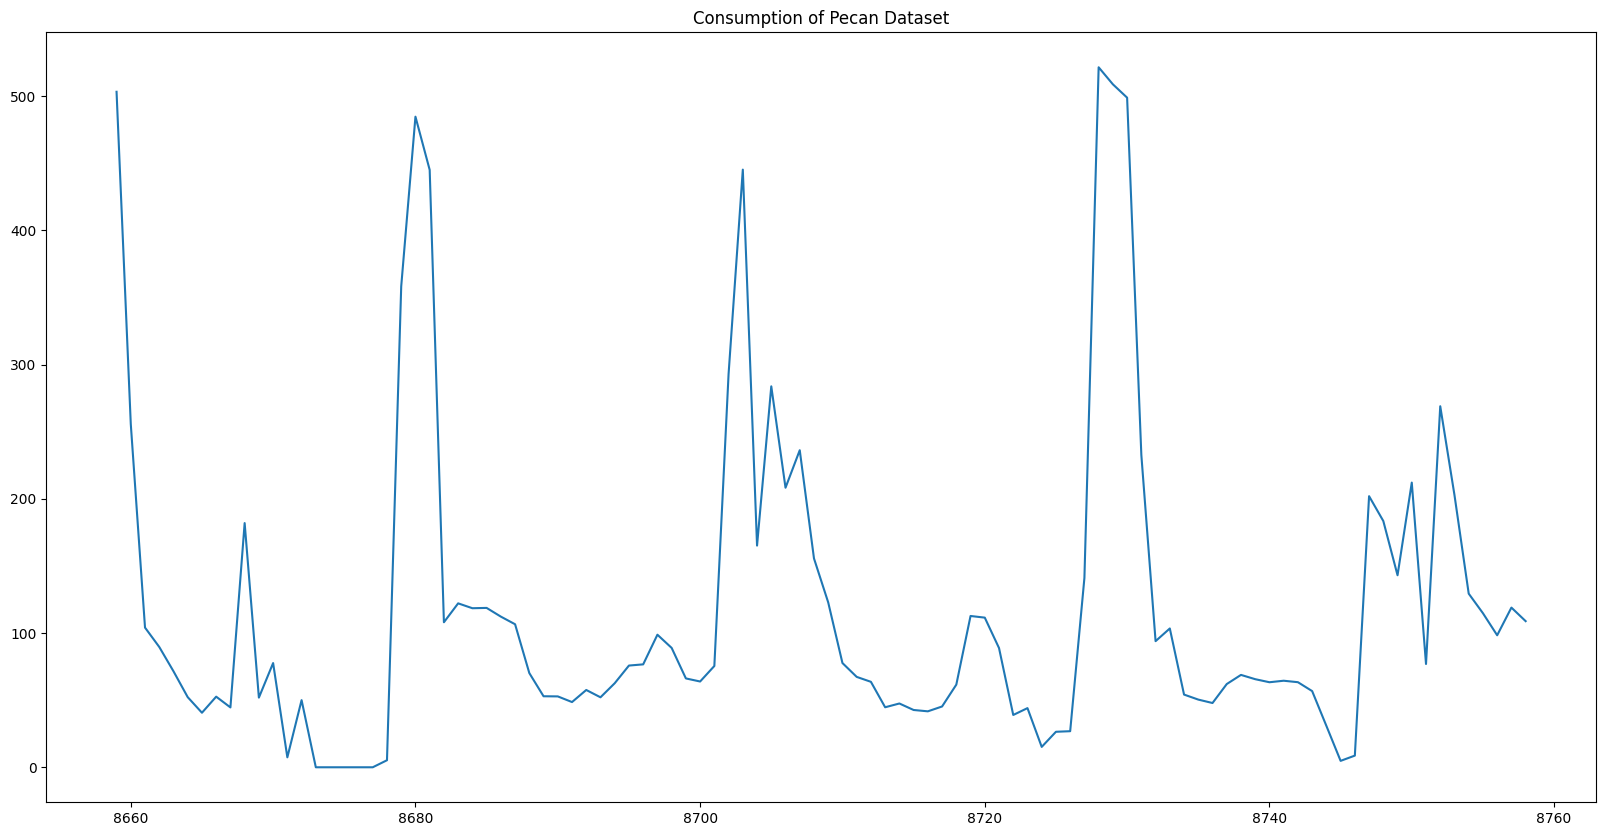

In [17]:
plt.figure(figsize=(20,10))
plt.title('Consumption of Pecan Dataset')
plt.plot(pecan_data.consumption[-100:])
plt.show()